In [1]:
import h5py
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mode

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from hbtp import HBTReader
from src import read

In [2]:
snap = 51
grav = "GR_b64n512"
nbins = 20
reader = HBTReader("./data/%s/subcat/" % grav)
haloes = reader.LoadHostHalos(snap)
haloes = haloes[read.ids(grav, snap)]

In [3]:
bin = 5

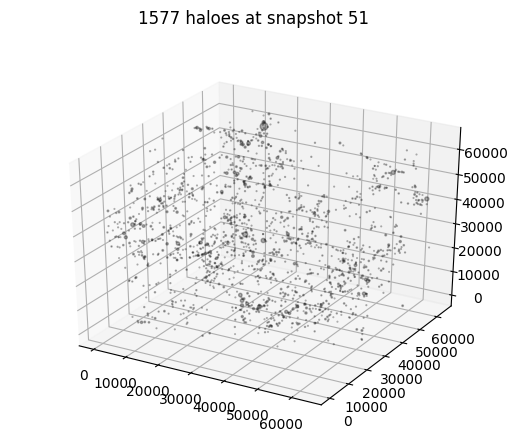

In [4]:
fig, ax = plt.subplots(1, subplot_kw={'projection': '3d'})
fig.suptitle("%d haloes at snapshot %d" % (len(haloes), snap))

ax.scatter(
    *haloes['CenterComoving'].T,
    s=30*(haloes['M200Crit'] / haloes['M200Crit'].max()),
    c='k', alpha=0.3
)

In [5]:
def nearest_neighbour(halo, f=1.0, N=0):
    """N-th neighbour more massive then f*M (M of halo h).
    
    .. todo::

        Error handling for small numbers of haloes

    """

    _haloes = haloes[
        (haloes["HaloId"] != halo["HaloId"])
        & (haloes["M200Crit"] >= f * halo["M200Crit"])
    ]

    if len(_haloes) < 1:
        d = np.nan

    else:
        d = (
            np.sort(
                np.sqrt(
                    np.sum(
                        np.power(
                            halo["CenterComoving"]
                            - _haloes["CenterComoving"],
                            2.0,
                        ),
                        axis=1,
                    )
                )
            )[N]
            / halo["R200CritComoving"]
        )

    return d

In [6]:
#TODO

def spherical_overdensity(halo, r=5):
    """(Over)density within radius ``r`` of halo center.
    """
    return 0.0

def shell_overdensity(halo, r_min=1, r=5):
    """(Over)density within shell between ``r_min`` and ``r``.
    """
    return 0.0

def experienced_potential(halo):
    """Experienced gravity for a halo.
    """
    c = halo['NFW_c']
    r_s = nfw.r_s(c)
    delta_c = nfw.delta_c(c)

    rs = np.linspace(-2.0, 0.0, 100)
    phi = [phi(r) for r in rs]

    phi_star = phi + 4*np.pi*G*delta_c * cosmology.rho_crit(halo['snap']) * \
        np.div((r_s * r_s * r_s), rs) * np.log(1.0 + rs / r_s)

    return np.mean(phi_star)

In [7]:
def plot3d(xs, ys, zs, ss, cs):
    ix = ~np.isnan(cs)
    xs, ys, zs, ss, cs = xs[ix], ys[ix], zs[ix], ss[ix], cs[ix]

    scalarMap = matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs)),
        cmap=plt.get_cmap('viridis')
    )
    scalarMap.set_array(cs)
    fig, ax = plt.subplots(1, figsize=[9, 7], subplot_kw={'projection': '3d'})
    fig.suptitle("%d haloes at snapshot %d, N=1, f=1.0" % (len(haloes), snap))
    fig.colorbar(scalarMap).ax.set_ylabel(r"$\log_{10}(D_{N,f})$", rotation=270)
    ax.set_xlabel(r"$x$"); ax.set_xticklabels([])
    ax.set_ylabel(r"$y$"); ax.set_yticklabels([])
    ax.set_zlabel(r"$z$"); ax.set_zticklabels([])
    ax.scatter(xs, ys, zs, s=ss, c=scalarMap.to_rgba(cs), alpha=1.0)
    fig.tight_layout()
    
    return fig, ax

In [8]:
dnf = np.log10([nearest_neighbour(halo) for halo in tqdm(haloes)])

100%|██████████| 1577/1577 [00:00<00:00, 2706.30it/s]


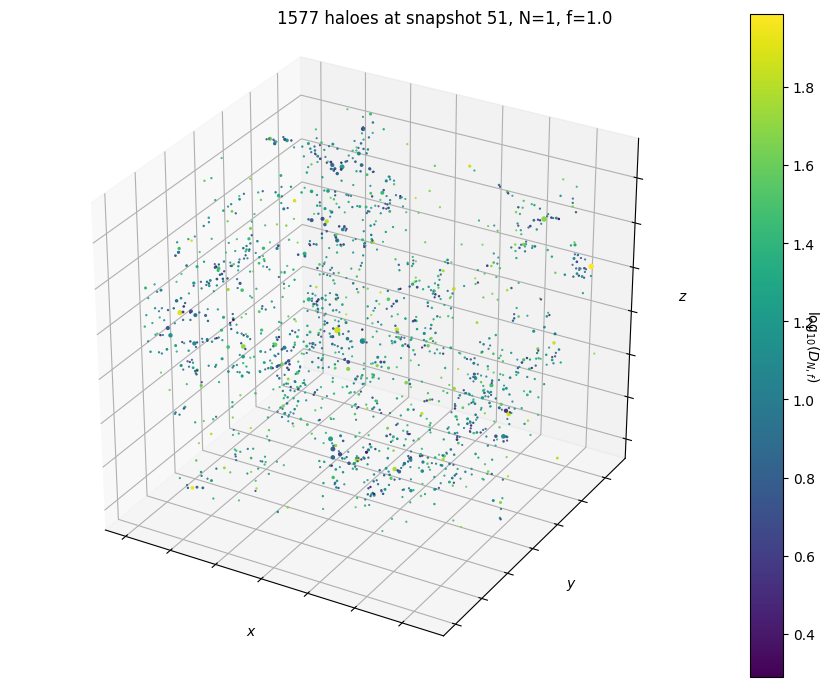

In [9]:
fig, ax = plot3d(
    *haloes['CenterComoving'].T,
    ss=30*(haloes['M200Crit'] / haloes['M200Crit'].max()),
    cs=dnf,
)

# fig.savefig("./3d.pdf")

In [10]:
d = pd.DataFrame({
    'm': np.log10(1e10*haloes['M200Crit']),
    'd': dnf,
})
d['m_bin'] = pd.cut(
    d['m'],
    np.linspace(
        d['m'].min(),
        d['m'].max(), nbins + 1
    ),
    retbins=False,
    labels=np.arange(1, nbins+1)
)

dnf_quantiles = d.groupby('m_bin').quantile([.40, .60])['d']
dnf_quantiles

m_bin     
1      0.4    1.018328
       0.6    1.199819
2      0.4    1.014495
       0.6    1.180154
3      0.4    0.974900
       0.6    1.150244
4      0.4    1.044912
       0.6    1.233068
5      0.4    1.078775
       0.6    1.228635
6      0.4    1.001357
       0.6    1.150345
7      0.4    1.209256
       0.6    1.348900
8      0.4    1.212248
       0.6    1.321592
9      0.4    1.243578
       0.6    1.491298
10     0.4    1.089451
       0.6    1.353770
11     0.4    1.230925
       0.6    1.458423
12     0.4    0.920801
       0.6    1.389410
13     0.4    1.111387
       0.6    1.245333
14     0.4    1.240866
       0.6    1.499258
15     0.4    1.774286
       0.6    1.834415
16     0.4    1.069210
       0.6    1.069210
17     0.4    1.861859
       0.6    1.861859
18     0.4         NaN
       0.6         NaN
19     0.4         NaN
       0.6         NaN
20     0.4         NaN
       0.6         NaN
Name: d, dtype: float64

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


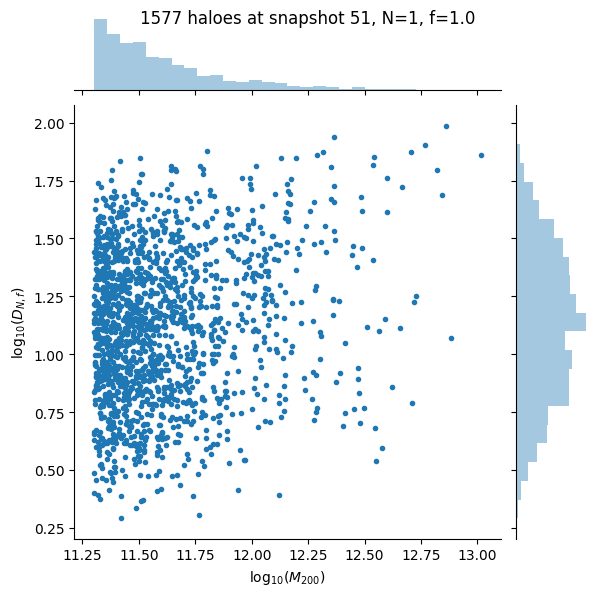

In [11]:
p = sns.jointplot(
    x="m", y="d",
    data=d,
    marker='.',
    stat_func=None,
)

p.fig.suptitle("%d haloes at snapshot %d, N=1, f=1.0" % (len(haloes), snap))
p.set_axis_labels(r"$\log_{10}(M_{200})$", r"$\log_{10}(D_{N,f})$")

In [12]:
dnf_quantiles.loc[1]

0.4    1.018328
0.6    1.199819
Name: d, dtype: float64

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


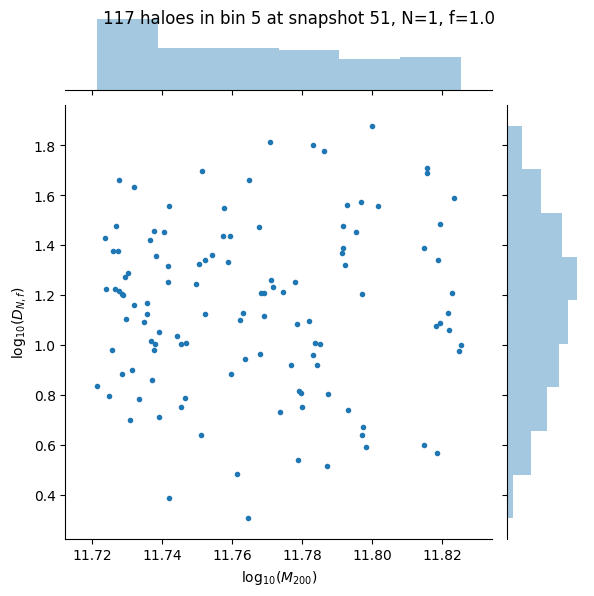

In [13]:
p = sns.jointplot(
    x="m", y="d",
    data=d[d['m_bin'] == bin],
    marker='.',
    stat_func=None
)

p.fig.suptitle(
    "%d haloes in bin %d at snapshot %d, N=1, f=1.0"
    % (len(d[d['m_bin'] == bin]), bin, snap))
p.set_axis_labels(r"$\log_{10}(M_{200})$", r"$\log_{10}(D_{N,f})$")